In [1]:
import os
import time
import random
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from PIL import Image
from IPython.display import clear_output

import ai2thor
import ai2thor_colab
from ai2thor_colab import plot_frames
from ai2thor.controller import Controller

from ai2thor.platform import CloudRendering
controller = Controller(platform=CloudRendering)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
from network import PolicyNetwork, ValueNetwork
from utils import to_torchdim, frame2tensor, plot_durations, encode_feedback

In [4]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

## Set Environment

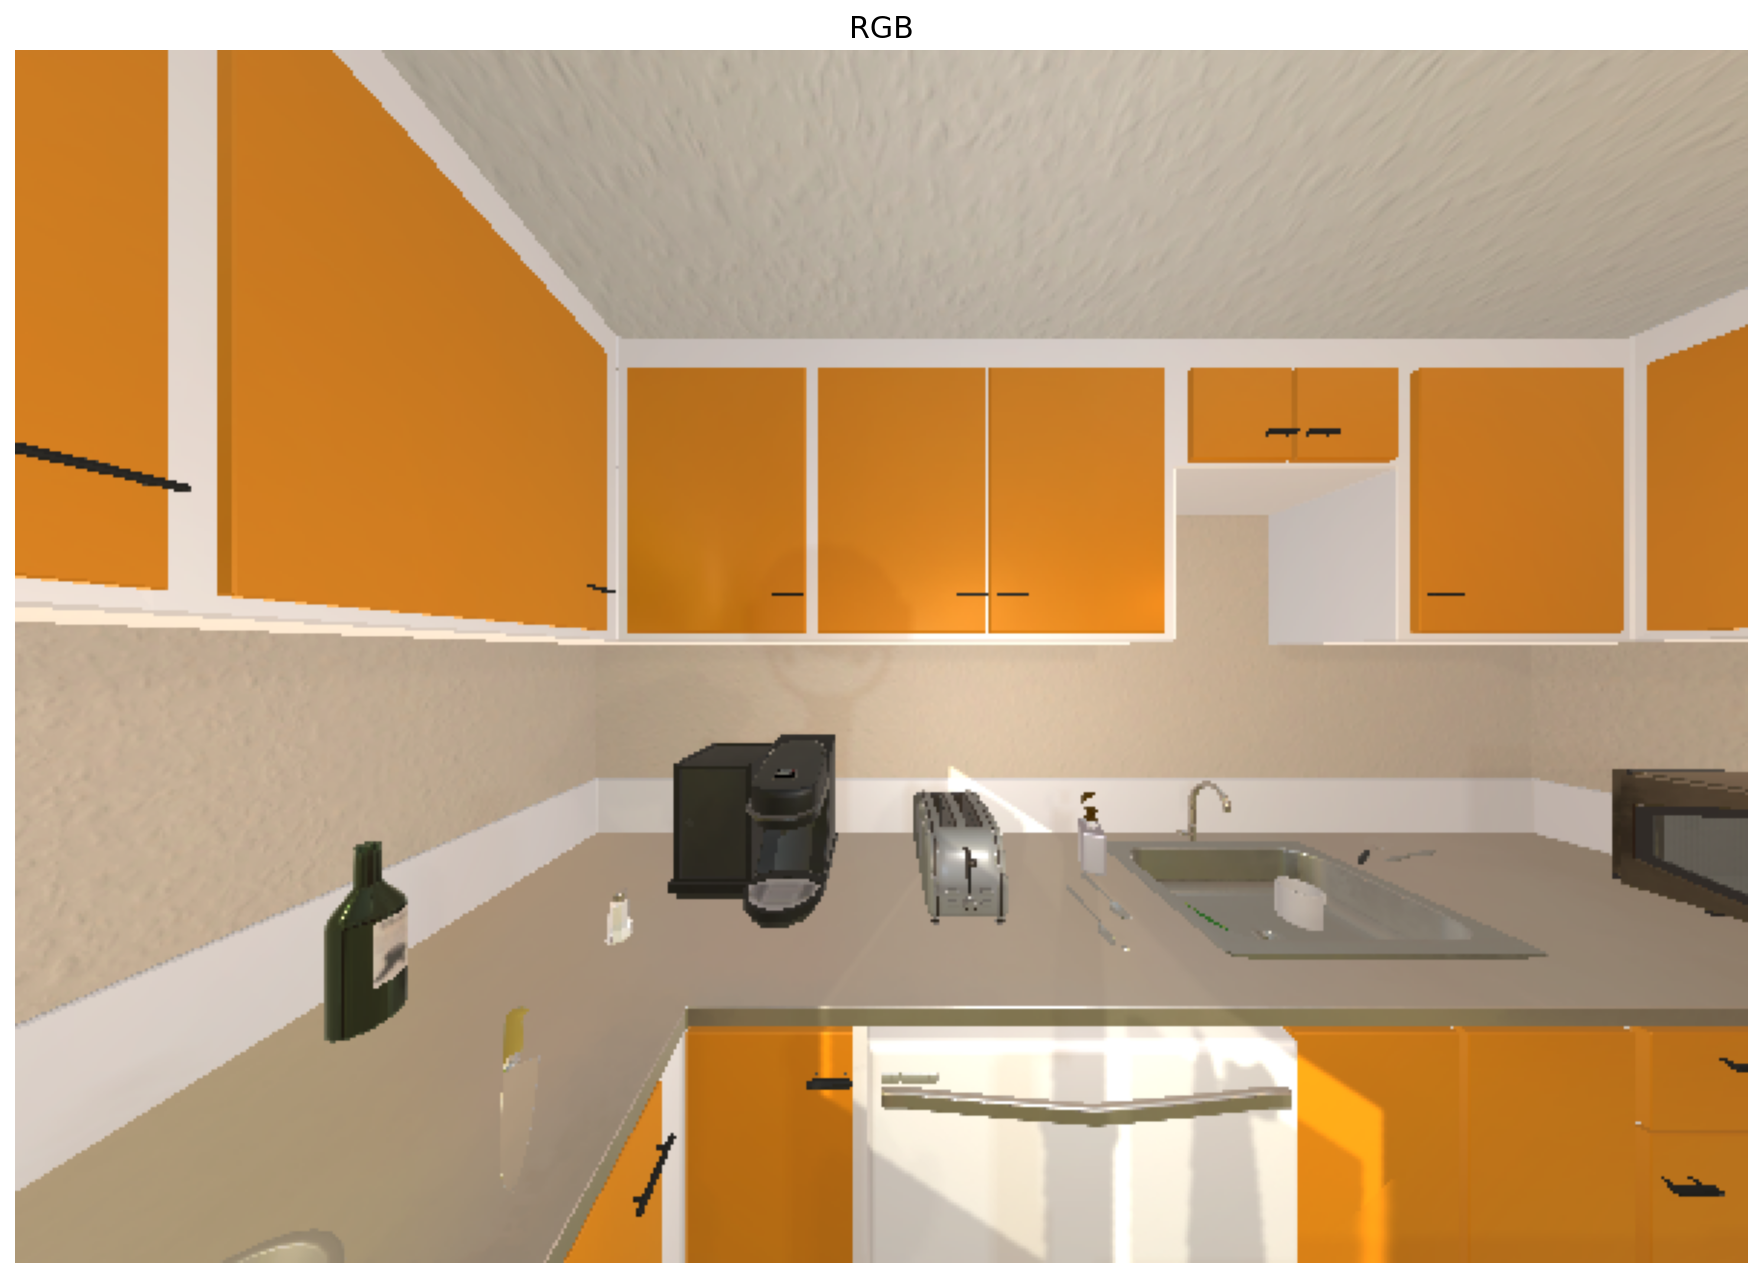

In [5]:
floor_index = random.randint(0, 30)
floor_index = 20

controller = Controller(
    agentMode = "default", # arm
    visibilityDistance = 0.5,
    scene = f"FloorPlan{floor_index}",

    # step sizes
    snapToGrid = True,
    gridSize = 0.25,
    rotateStepDegrees = 90,

    # image modalities
    renderInstanceSegmentation = False,
    renderDepthImage = False,
    renderSemanticSegmentation = False,
    renderNormalsImage = False,
    
    # camera properties
    width = 600,
    height = 420,
    fieldOfView = 120,
)

plot_frames(controller.last_event)

## Set Configs

In [6]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [7]:
BATCH_SIZE = 64
GAMMA = 0.999 # discounted return
NUM_EPISODES = 3000

LR = 2.5e-4

SCREEN_WIDTH = SCREEN_HEIGHT = 100

AGENT_TARGET = "LightSwitch_bf8119ce"

In [8]:
action_space = ["MoveAhead", "MoveLeft", "MoveRight", "MoveBack", "RotateLeft", "RotateRight"]

In [9]:
data = controller.last_event.metadata['objects']
object_space = [item['name'] for item in data]

## Build Agent

In [10]:
class A2CAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, screen_width, screen_height, action_size, seed):
        
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.hidden_size = 256
        self.action_size = action_size
        
        # Initialize actor and critic networks
        self.actor = PolicyNetwork(self.screen_width, self.screen_height, self.hidden_size, self.action_size, seed).to(device)
        self.critic = ValueNetwork(self.screen_width, self.screen_height, self.hidden_size, 1, seed).to(device)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR)
    
    def preprocess(self, state, screen_width, screen_height):
        """Preprocess input frame before passing into agent."""
        
        resized_screen = Image.fromarray(state).resize((screen_width, screen_height))
        state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)

        return state
    
    def act(self, state):
        """Returns actions for given state as per current policy."""
        
        state = torch.FloatTensor(state).to(device)
        probs = self.actor(state)
        m = Categorical(probs)
        
        action_probs = m.sample()
        action = action_probs.cpu().detach().item()
        
        return action
    
    def learn(self, trajectory):
        
        policy_loss, value_loss = self.compute_loss(trajectory)
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        
        return policy_loss, value_loss
    
    def compute_loss(self, trajectory):
        
        states = torch.FloatTensor(np.vstack([sarsa[0].cpu().numpy() for sarsa in trajectory if sarsa is not None]))
        states = states.to(device)
        
        actions = torch.LongTensor(np.vstack([sarsa[1].cpu().numpy() for sarsa in trajectory if sarsa is not None])).view(-1, 1)
        actions = actions.to(device)
        
        rewards = torch.FloatTensor(np.vstack([sarsa[2].cpu().numpy() for sarsa in trajectory if sarsa is not None]))
        rewards = rewards.to(device)
        
        next_states = torch.FloatTensor(np.vstack([sarsa[3].cpu().numpy() for sarsa in trajectory if sarsa is not None]))
        next_states = next_states.to(device)
        
        dones = torch.FloatTensor([sarsa[4] for sarsa in trajectory if sarsa is not None]).float().view(-1, 1)
        dones = dones.to(device)
        
        # compute value target
        discounted_rewards = [torch.sum(torch.FloatTensor([GAMMA**i for i in \
                              range(rewards[j:].size(0))]) * rewards[j:]) for j in range(rewards.size(0))]
        
        # rewards plus next state values
        rewards = rewards.view(-1, 1) + torch.FloatTensor(discounted_rewards).view(-1, 1).to(device)
        
        # compute value loss
        state_values = self.critic(states)
        value_loss = F.mse_loss(rewards.detach(), state_values)
        
        # compute policy loss with entropy bonus
        probs = self.actor(states)
        m = Categorical(probs)
        
        # compute entropy bonus
        dist_entropy = []
        for prob in probs:
            dist_entropy.append(-torch.sum(prob.mean() * torch.log(prob)))
        dist_entropy = torch.stack(dist_entropy).sum()
        
        # compute advantage function to calculate the extra reward get by agent and to avoid high variability
        advantages = rewards - state_values # TD estimate as a baseline
        policy_loss = -m.log_prob(actions.view(actions.size(0))).view(-1, 1) * advantages.detach()
        policy_loss = policy_loss.mean() - 0.001 * dist_entropy
        
        return policy_loss, value_loss
    
    def save(self, actor_path, critic_path):
        
        if not os.path.exists('./agents/'): os.makedirs('./agents/')
        torch.save(self.actor.state_dict(), actor_path); torch.save(self.critic.state_dict(), critic_path)
    
    def watch(self, controller, num_episodes=10):
        """Watch trained agent."""
        best_score = -np.inf

        for i_episode in range(1, num_episodes+1):

            # initialize the environment and state
            controller.reset(random=True)

            screen = controller.last_event.frame
            resized_screen = Image.fromarray(screen).resize((SCREEN_WIDTH, SCREEN_HEIGHT))

            state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)

            total_score = 0

            for time_step in range(1, 100):

                # select an action using the trained dqn network
                if time_step == 1 or time_step == 2 or time_step == 3:
                    action = torch.tensor([[random.randint(0, self.action_size-1)]]).to(device)
                else:
                    with torch.no_grad():
                        action = self.act(state)

                event = controller.step(action = action_space[action.item()])

                time.sleep(1)
                
                _, reward, done, _ = encode_feedback(event, controller, target_name=AGENT_TARGET)

                # observe a new state
                if not done:
                    screen = controller.last_event.frame
                    resized_screen = Image.fromarray(screen).resize((SCREEN_WIDTH, SCREEN_HEIGHT))

                    next_state = frame2tensor(to_torchdim(resized_screen)).to(torch.float32).to(device)
                else:
                    next_state = None

                state = next_state
                total_score += reward
                if done:
                    break

            if total_score > best_score: 
                best_score = total_score

            print(f'\rEpisode {i_episode}/{num_episodes}, Total Score: {total_score}, Best Score: {best_score}', end='') 

In [11]:
agent = A2CAgent(screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT, action_size=len(action_space), seed=90)

## Train DQN

In [12]:
def train_agent(num_episodes, max_time):
    
    scores = []
    policy_loss_plot = []; value_loss_plot = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, num_episodes+1):
        
        # initialize the environment and state
        controller.reset(random=True)
        
        state = agent.preprocess(controller.last_event.frame, 
                                 screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT)
                                  
        total_score = 0        
        trajectory = []
        
        for time_step in range(max_time):
            action = agent.act(state)
            action = torch.tensor([[action]])
            
            event = controller.step(action = action_space[action.item()])
            
            _, reward, done, _ = encode_feedback(event, controller, target_name=AGENT_TARGET)
            total_score += reward
            reward = torch.tensor([reward], device=device)
            
            next_state = agent.preprocess(controller.last_event.frame, 
                                          screen_width=SCREEN_WIDTH, screen_height=SCREEN_HEIGHT)
            
            trajectory.append([state, action, reward, next_state, done])
            
            # move to the next state
            state = next_state
            
            if done or time_step==max_time:
                plot_durations(total_score, i_episode, num_episodes)
                break
                
        policy_loss, value_loss = agent.learn(trajectory)
        policy_loss_plot.append(policy_loss); value_loss_plot.append(value_loss)
        
    if not os.path.exists('./agents/'): os.makedirs('./agents/')
    torch.save(agent.dqn_net.state_dict(), f'./agents/AI2THOR_RL.pth')
                
    print('Training completed.')
    plt.ioff()
    plt.show()

In [13]:
print('Training the agent...')
train_agent(num_episodes=NUM_EPISODES, max_time=400)

Training the agent...


ValueError: Expected parameter probs (Tensor of shape (1, 6)) of distribution Categorical(probs: torch.Size([1, 6])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan]], grad_fn=<DivBackward0>)

## Check The Result!

In [ ]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/AI2THOR_RL.pth'));

In [ ]:
agent.watch(controller, num_episodes=10)

In [ ]:
controller.stop()

In [ ]:
# 14.00 - 15.00 AI2THOR
# 15.00 - 16.00 Japanese
# 16.00 - 17.30 WayangLLM
# 17.30 - 19.00 Read Algorithm Book

---